# Deep Learning 101

<div class="alert alert-success">
This lecture takes a practical approach to introduce modern deep learning approaches.  It provides foundational deep learning knowledge in order for you to move onto time series forecasting.
</div>

**By the end of this lecture you will have:**
    
* Developed a conceptual understanding of modern deep neural networks.
* Built intuition about what hidden layers within a deep network are doing and how they aid prediction.
* Understand the definition and benefits of mini batches of training data
* Built intuition about how networks 'learn' using the backpropogation algorithm and stochastic gradient descent.
* Learnt how to build simple neural network architectures in Keras and Tensorflow 2.0
* The foundational knowledge to move onto using feedforward neural networks for time series forecasting.

# Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keras and Tensorflow Imports

For your deep learning you will make use of [Keras](https://keras.io/).  This is a python library that sits on top of Google's deep learning toolset: Tensorflow 2.0.  Keras makes deep learning relatively straightfoward because it hides a lot of the complexity of Tensorflow. 

> Another very powerful deep learning framework is [PyTorch](https://pytorch.org/).  This is a pythonic deep learning toolkit and is also very powerful.  Our research experience is that PyTorch is more efficient than Keras and Tensorflow (sometimes by a considerable margin), but that it requires more code to do the same things as Keras.  Another way to look at this is that Keras comes with 'more bells and whistles' than PyTorch and for learning that comes in very handy!  The exercises that you will tackle in this course are written in Keras/TF, but you will also have access to optional material written in PyTorch.

In [2]:
import tensorflow as tf
from tensorflow import keras

# if using hds_forecast this should be version 2.15
print(tf.__version__)

2024-07-30 17:08:53.838345: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 17:08:54.004878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


# Computational cost of deep learning

When you have a complex deep learning architecture (which isn't always the case) and lots of data you should expect it to be more computationally expensive (take longer to run and work your CPU hard) than other types of ML.  In these instances, you really need a powerful machine and for some models a GPU.  For **time series forecasting**, we will be using the OpenStack on the High Performance Cluster, but for personal learning and coursework you can also make use of Google Colaboratory (Jupyter in the cloud).  Google also provide a GPU.  All of the neural network notebooks in this course are runnable in Google Colab. 

# A first look at Deep Learning using Tensorflow Playground

[Tensorflow playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.55467&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) is provided by Google.  I recommend that you spend some time using it as it helps build intuition about how deep learning works.

# Components needed for deep learning.

## 1. Training and test data

The data for this lecture is a real dataset known as the [Wisconsin Breast Cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) dataset. The data set consists of individual   we will use a **Feedforward Neural Network Architecture.**

The data are published and open; feel free to take a look at them in more detail.

> The dataset contains 30 features and a binary label (benign/malignant)

In [3]:
url = 'https://raw.githubusercontent.com/MichaelAllen1966/' \
       + 'synthetic_data_pilot/main/01_wisconsin/wisconsin.csv'
cancer = pd.read_csv(url)

In [4]:
# Load data and drop 'id' column
cancer.drop('id', axis=1, inplace=True)

# Change 'diagnosis' column to 'malignant', and put in last column place
cancer['malignant'] = cancer['diagnosis'] == 'M'
cancer.drop('diagnosis', axis=1, inplace=True)

In [5]:
# 30 features and a single binary (0/1) label
cancer.shape

(569, 31)

In [6]:
cancer.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,True
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,True
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,True
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,True
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,True


# Train-Test Split

Just like other Machine Learning approaches we first do a train test split (and do not look at or use our test data until we are ready!).

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# split into x and y for split
X = cancer[cancer.columns[:-1]]
y = cancer['malignant']

In [9]:
# setting random_state means we always get the same split
X_train, X_test, y_train, y_test \
    = train_test_split(X.to_numpy(), y.to_numpy(), 
                       test_size=0.20, 
                       random_state=42)

In [10]:
print(X_train.shape)
print(X_test.shape)

(455, 30)
(114, 30)


In [11]:
# class balance
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(unique_elements, counts_elements)
print(y_train.mean())

[False  True] [286 169]
0.37142857142857144


# Rescale data

You should always rescale the features that you use to train a neural network.

I recommend scaling **after** a train-test split where the scaler uses the **training** data.  In a production setting you cannot scale on the data you are about to predict!  You should aim to simulate this setting and avoid leakage!

Here we will use [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to rescale features to range from 0 to 1.

In [12]:
# we will rescale all data to be between 0 and 1
from sklearn.preprocessing import MinMaxScaler

In [13]:
# do the rescaling and assign to dataframe
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)

# scale training data (cast to dataframe)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_train_scaled.columns = cancer.columns[:-1]

# scale test data (cast to dataframe)
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_test_scaled.columns = cancer.columns[:-1]

# take a look at the rescaled data
print(X_train_scaled.shape)
X_train_scaled.head()

(455, 30)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.065527,0.257694,0.077323,0.034369,0.487226,0.417506,0.733365,0.217445,0.504004,0.642376,...,0.059645,0.283316,0.055971,0.025084,0.523195,0.449380,1.000000,0.601375,0.524936,0.529502
1,0.656203,0.570172,0.674207,0.489402,0.554934,0.903431,0.582709,0.743539,0.655633,0.505897,...,0.657920,0.571962,0.620253,0.462832,0.529308,0.802879,0.541534,0.997595,0.499310,0.621906
2,0.072579,0.140345,0.080239,0.038831,0.221901,0.233306,0.140300,0.108350,0.626802,0.414280,...,0.048681,0.192164,0.056428,0.021462,0.184677,0.154303,0.111581,0.174811,0.338459,0.253137
3,0.144914,0.524518,0.142908,0.075774,0.396678,0.181357,0.055740,0.080268,0.389749,0.280750,...,0.130546,0.617537,0.119414,0.057587,0.534742,0.123555,0.089856,0.210859,0.363493,0.224059
4,0.121407,0.174839,0.118296,0.060714,0.548614,0.209677,0.025398,0.064115,0.841431,0.413648,...,0.085593,0.144723,0.078135,0.035977,0.382599,0.078376,0.017316,0.088625,0.392667,0.213293


## Sequential layers and activation functions

Feedforward neural networks accept a vector of quantitative values as input and pass this through a sequence of fully connected layers (all neurons are connected to each other).  Each neuron in a layer recieves input from all of the neurons in the previous layer. The neuron weights the input vector, adds bias and then passes it through an activation function. In a hidden layer, for example, you could use a Rectified Linear Unit (ReLU; $f(x) = \max\left(0, x\right)$).  

The final layer is an **output** layer.  The thrombolysis example is a binary classification so the output layer is a fully connected layer with a single neuron.  You will need to use a `sigmoid` activation function to provide a probability of recieving thromboysis between 0.0 and 1.0.

For feedforward networks, `Keras` provides simple classes to help you construct your model.

In [14]:
# a model consisting of a sequential set of layers
from tensorflow.keras.models import Sequential

# a fully connected layer, an input layer
from tensorflow.keras.layers import Dense, Input

In [15]:
# The first input
model = Sequential(name='breast_cancer_nn')

# input layer shape = (no. features, )
model.add(Input(shape=(X_train.shape[1],)))

# hidden layer 1: relu: f(x) = max(0, x)
model.add(Dense(units=10, activation='relu'))

# hidden layer 2
model.add(Dense(units=10, activation='relu'))

# output layer
model.add(Dense(units=1, activation='sigmoid'))

# summary including number of trainable parameters
model.summary()
          

Model: "breast_cancer_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                310       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 431 (1.68 KB)
Trainable params: 431 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training a network

For each neuron you can think of the weights as the **strength** of the neuron's **connections** to all of the neurons in the **previous layer**.  The network is initialised with these weights set to **random** values.  The purpose of training is therefore to find the 'best' weights for your prediction problem.   

In this context, 'best' means the weights that minimise the training **loss** (sometimes called **cost** or **error**).  Loss is a measure of model fit i.e. a metric quantifying the difference between the predictions from the model and the ground truth observations. For classification models, you will use **Binary Cross-Entropy**.  For each training example, this measure simply takes the -log of the probability the model assigned to the correct label and then averages across all samples.  Or more formally, $$-\dfrac{1}{N} \sum_{i=1}^N y_i \cdot log(p(y_i)) + (1 - y_i) \cdot log(1 - p(y_i))$$ 

where $y$ is the 0/1 label and $p(y_i)$ is the probability (0 to 1) assigned to predicting label $i$.  

> Note that in a regression model, you would use a loss metric such as **Mean Absolute Error** or **Mean Squared Error**.

In [16]:
# let's assume these are the probs assigned to a TRUE value
cost = [0.1, 0.2, 0.8, 0.99]
-np.log(cost)

array([2.30258509, 1.60943791, 0.22314355, 0.01005034])

### Stochastic Gradient Descent and Backpropagation

Think of finding the best weights for your model as a large scale optimisation problem. Even in the simple first model we created there were 400+ parameters to optimise! To optimise these weights an algorithm is needed to estimate the gradient of the loss function and taking a **step** to gradually **decend** it into a local optima. 

<img src="gradient1.png" alt="drawing" width="500"/>

Finding these local optima is achieved using the **backpropagation algorithm** and **stochastic gradient descent**.  After pushing a training sample through our binary classification network we get a single probability of the patient having cancer. We also have the ground truth value labelling if the patient has a malignant tumor or not. Starting from the networks output layer, backprop works backward through each layer of the network to find the weights and biases that correctly classify the patient. This is repeated for all of the training data and the average of these values is the gradient of the loss function with respect to each weight. Repeated enough times the networks weights will converge on solution that minimises the loss. 

<img src="iteration.png" alt="drawing" width="400"/>

For large networks and datasets this is computationally expensive (and possibly infeasible) to run backpropagation against every training sample individually. Therefore we use **stochastic gradient decent (SGD)** to estimate the gradient.  The gradient is estimated by averaging results after breaking the dataset into random **mini-batches** (subsets). This reduces number of computations needed by a substantial amount (and makes large problems tractible).  

<img src="yanlcun.png" alt="drawing" width="600"/>

The size of the step taken at each iteration is called the **learning rate**. It is used to subtract a fraction of the gradient from the current weights. The learning rate is a hyperparameter and may need tuning.  A typical starting point is to try powers of 10; for example, 0.1, 0.01, 0.001.  A larger step means that you can descend more quickly!  The downside is that you might overshoot the minimum!  

In practice, SGD is not quite so simple and there are a few other concepts and optimisations procedures to appreciate.  The first is that it useful to tweak SGD to have **momentum**. The modification adds a fraction (typically 0.9) of the previous update to weights. The second is adapative learning rates. This comes in different flavours from a simple reduction in learning rate over time to varying the learning rate by parameter.  Both momentum and adaptive learning rates help SGD converge more efficiently.

<img src="overshoot.png" alt="drawing" width="400"/>



### Training in Keras

In Keras, the complexity described above is hidden and you simply **compile** a model and choose an `optimizer` and `loss` function.  You then call the model's `fit` method and pass in the training data, mini batch size (32 is the default) and the number of **epochs** to run.  An epoch is a single pass through all of the training data.  If, for example, there are 1000 points and you are using a mini-batchs of 100 then there are 10 iterations within a single epoch.  You need to run multiple epochs for the network to descend the loss function.

I recommend you choose the Adam optimiser.  This is the most popular version of stochastic gradient descent since about 2015.  

In [17]:
# set the optimizer, loss function and also report classification accuracy
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit the model and include a validation split to check for overfitting. 
results = model.fit(x=X_train_scaled.to_numpy(), 
                    y=y_train, 
                    batch_size=32,
                    validation_split=0.10, 
                    epochs=200, 
                    verbose=0)

In [18]:
def plot_loss(results):
    '''
    Two charts 1.) train versus validation loss and 2.) accuracy
    '''
    fig, ax = plt.subplots(2, 1, figsize=(12,6))
    ax[0].plot(results.history['loss'])
    ax[0].plot(results.history['val_loss'])
    ax[0].legend(['loss', 'val_loss'])
    ax[1].plot(results.history['accuracy'])
    ax[1].plot(results.history['val_accuracy'])
    ax[1].legend(['accurracy', 'val accurracy'])

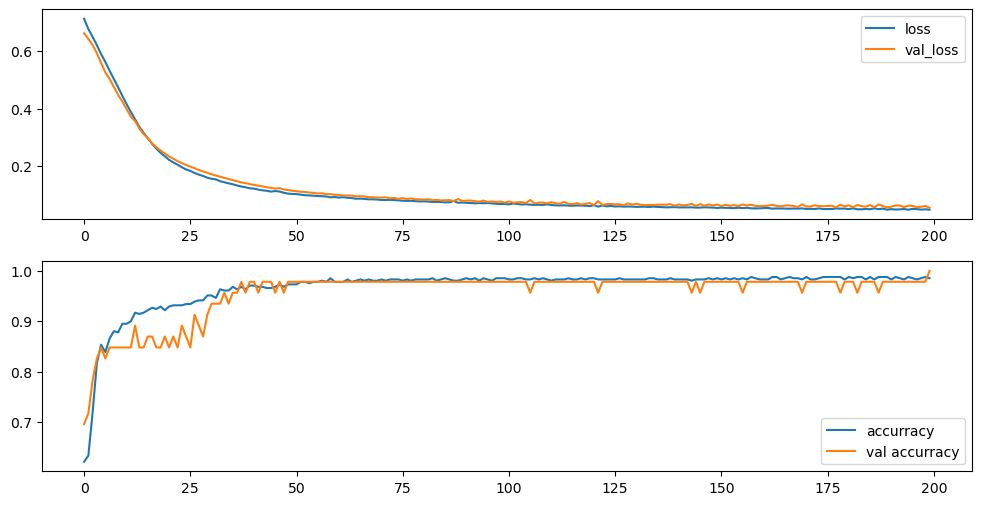

In [19]:
plot_loss(results)

# Overfitting

Given enough capacity, neural networks will overfit to your training data.  Models that are overfitted have highly variable performance when used for prediction.  Keras provides a couple of simple mechanisms to reduce overfitting: **dropout layers** and **early stopping callbacks**.


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [21]:
def get_model(input_size, n_hidden=2, n_neurons=10, activation='relu', 
              dropout=False, d_rate=0.2):
    '''
    Create a simple Keras feedforward model.
    '''
    #The first input
    model = Sequential(name='breast_cancer_nn')

    #input layer.
    model.add(Input(shape=(input_size,)))

    for i in range(n_hidden):
        #hidden layer 1 
        model.add(Dense(units=n_neurons, activation=activation))
        #include a dropout layer
        if dropout:
            model.add(Dropout(d_rate))
    
    #output layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    return model

Model: "breast_cancer_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                992       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)            

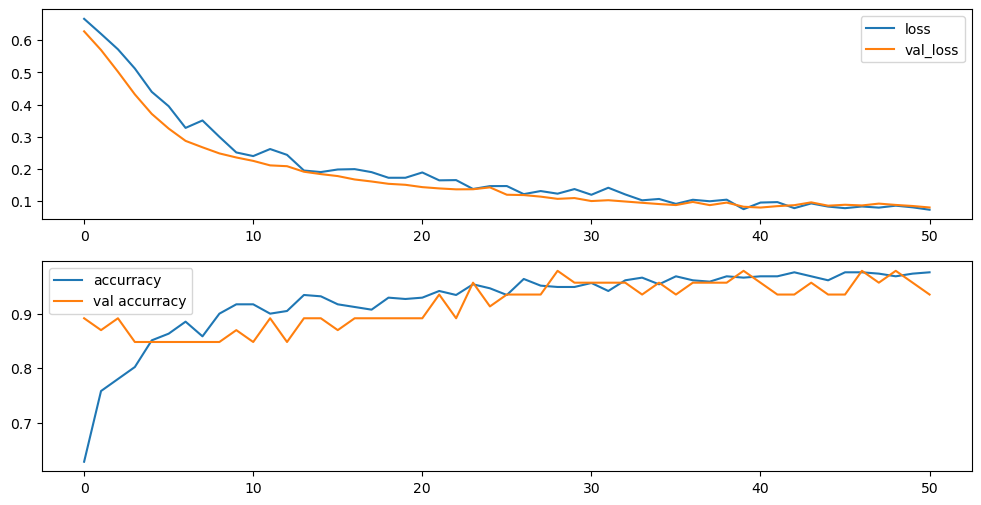

In [22]:
############ General Parameters ############################

N_HIDDEN = 3
N_NEURONS = 32
N_EPOCHS = 200

# 0 fit silently; 1 show results per epoch
VERBOSE = 0

########### Regularization options ########################
INCLUDE_DROPOUT = True
DROPOUT_RATE = 0.2

INCLUDE_EARLY_STOP = True
PATIENCE = 10

#create an early stopping callback
es = EarlyStopping(monitor='val_loss', 
                   patience=PATIENCE,
                   restore_best_weights=True)

###########################################################

#include early stopping?
callbacks = []
if INCLUDE_EARLY_STOP:
    callbacks.append(es)

#get the custom feedforward model
model_2 = get_model(input_size=X_train.shape[1], 
                    n_hidden=N_HIDDEN,
                    n_neurons=N_NEURONS,
                    dropout=INCLUDE_DROPOUT,
                    d_rate=DROPOUT_RATE)

#summary to remind us what we have built!
print(model_2.summary())

#compile the new model
model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])


#fit the model and also pass in the callback
results_2 = model_2.fit(x=X_train_scaled, 
                        y=y_train, 
                        batch_size=32,
                        validation_split=0.10, 
                        epochs=N_EPOCHS, 
                        verbose=VERBOSE,
                        callbacks=callbacks)

#plot loss and val loss
plot_loss(results_2)


# Prediction

Predicting the training set very straightforward making use of the models `.predict()` method.  

> When predicting results for individual patients you will need to `.reshape` your input

In [23]:
X_test_scaled.to_numpy()[0].shape

(30,)

In [24]:
X_test_scaled.to_numpy()[0].reshape(1, -1).shape

(1, 30)

### Predicting and individual patients result

In [25]:
test_id = 1

pred = model_2.predict(x=X_test_scaled.to_numpy()[test_id].reshape(1, -1))[0,0]
print(f'prediction proba {pred:.2f}')
print(f'prediction: {pred >= 0.5}')
print(f'ground truth value: {y_test[test_id]}')

1/1 [==============================] - 0s 68ms/step
prediction proba 1.00
prediction: True
ground truth value: True


In [26]:
model_2.predict(x=X_test_scaled.to_numpy()[test_id].reshape(1, -1))[0, 0]

1/1 [==============================] - 0s 17ms/step


0.99928105

### Predicting the full test set

In [27]:
y_pred = model_2.predict(x=X_test_scaled.to_numpy()).flatten()
np.round(y_pred, 3)

4/4 [==============================] - 0s 1ms/step


array([0.062, 0.999, 0.993, 0.002, 0.001, 1.   , 1.   , 0.969, 0.61 ,
       0.011, 0.028, 0.981, 0.014, 0.534, 0.008, 0.998, 0.005, 0.   ,
       0.   , 1.   , 0.344, 0.005, 1.   , 0.001, 0.006, 0.   , 0.018,
       0.017, 0.005, 0.999, 0.003, 0.002, 0.001, 0.006, 0.001, 0.003,
       0.839, 0.004, 0.998, 0.037, 0.001, 0.991, 0.007, 0.008, 0.007,
       0.041, 0.   , 0.003, 0.015, 0.033, 0.998, 1.   , 0.19 , 0.003,
       0.   , 0.083, 0.002, 1.   , 0.983, 0.002, 0.009, 1.   , 1.   ,
       0.048, 0.004, 0.175, 0.999, 1.   , 0.002, 0.019, 0.982, 0.994,
       0.009, 0.99 , 0.001, 0.009, 0.015, 0.556, 0.005, 0.004, 0.989,
       0.001, 0.675, 1.   , 0.985, 0.996, 0.991, 0.997, 0.015, 0.004,
       0.004, 0.334, 0.047, 0.005, 0.001, 0.001, 0.999, 0.999, 0.001,
       0.993, 0.988, 0.   , 0.999, 0.996, 0.009, 0.025, 0.009, 1.   ,
       0.15 , 0.066, 0.993, 0.004, 0.183, 1.   ], dtype=float32)

### quick reminder of classification metrics

TP = True positives
FP = False positives
TN = True negatives
FN = False negatives

$precision = \dfrac{TP}{TP + FP}$  e.g if model predicts a patient does have a maligant tumor with precision 0.8.  Then when a model makes a positive cancer prediction it is right about 80% of the time.

$recall = sensitivity = \dfrac{TP}{TP + FN}$ I.e. The proportion of true positive identified. 

$specificity =  \dfrac{TN}{TN + FP}$  How many negative classifications are actually negative?

For the Winconsin breast cancer dataset we want a high sensitivity (detecting as many patients tumors as possible), but not at the cost of specificity (lots of false positives).

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
#get predictions
y_pred = model_2.predict(x=X_test_scaled.to_numpy()).flatten()

4/4 [==============================] - 0s 1ms/step


In [30]:
#predictions are probabilities that the patient has a malignant tumour
np.round(y_pred, 2)

array([0.06, 1.  , 0.99, 0.  , 0.  , 1.  , 1.  , 0.97, 0.61, 0.01, 0.03,
       0.98, 0.01, 0.53, 0.01, 1.  , 0.01, 0.  , 0.  , 1.  , 0.34, 0.01,
       1.  , 0.  , 0.01, 0.  , 0.02, 0.02, 0.  , 1.  , 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.84, 0.  , 1.  , 0.04, 0.  , 0.99, 0.01, 0.01,
       0.01, 0.04, 0.  , 0.  , 0.01, 0.03, 1.  , 1.  , 0.19, 0.  , 0.  ,
       0.08, 0.  , 1.  , 0.98, 0.  , 0.01, 1.  , 1.  , 0.05, 0.  , 0.18,
       1.  , 1.  , 0.  , 0.02, 0.98, 0.99, 0.01, 0.99, 0.  , 0.01, 0.02,
       0.56, 0.  , 0.  , 0.99, 0.  , 0.68, 1.  , 0.98, 1.  , 0.99, 1.  ,
       0.02, 0.  , 0.  , 0.33, 0.05, 0.  , 0.  , 0.  , 1.  , 1.  , 0.  ,
       0.99, 0.99, 0.  , 1.  , 1.  , 0.01, 0.02, 0.01, 1.  , 0.15, 0.07,
       0.99, 0.  , 0.18, 1.  ], dtype=float32)

In [31]:
#view as 0/1
THRESHOLD = 0.5
(y_pred >= THRESHOLD).astype('int')

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [32]:
#classification results
THRESHOLD = 0.5
tn, fp, fn, tp = confusion_matrix(y_test, y_pred >= THRESHOLD).flatten()

#sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'sensitivity {sensitivity:.3f}')
print(f'specificity {specificity:.3f}')

sensitivity 0.977
specificity 0.986


In [33]:
report = classification_report(y_test, y_pred >= THRESHOLD, digits=3)
print(report)

              precision    recall  f1-score   support

       False      0.986     0.986     0.986        71
        True      0.977     0.977     0.977        43

    accuracy                          0.982       114
   macro avg      0.981     0.981     0.981       114
weighted avg      0.982     0.982     0.982       114



# Prediction Uncertainty

One issue with neural networks is that they don't automatically produce estimates of uncertainty.  This is problematic as they have been trained using stochastic gradient descent. 

One way to get an estimate of uncertainty from a neural network is to use **Monte Carlo Dropout**.  We have already learnt about `Dropout` layers and using them for regularisation.  What perhaps isn't clear is that when we make a prediction with a Keras model the `Dropout` layers are turned **off**.  If we instead turn them **on** and making a large number of predictions from the same data produce a distribution of predictions.  

> The below will only work **if you include dropout layers in your model!**

In [34]:
#get predictions
sample_no = 77
y_pred = model_2.predict(x=X_test_scaled.to_numpy()[sample_no].reshape(1, -1)).flatten()
print(np.round(y_pred, 3))

1/1 [==============================] - 0s 17ms/step
[0.556]


In [35]:
y_test[sample_no]

True

In [36]:
y_probas = [model_2(X_test_scaled.to_numpy()[sample_no].reshape(1, -1), training=True) 
            for sample in range(100)]

y_probas = np.round(np.stack(y_probas).flatten(), 2)
y_probas

array([0.75, 0.41, 0.84, 0.81, 0.26, 0.84, 0.45, 0.9 , 0.54, 0.77, 0.75,
       0.72, 0.82, 0.38, 0.89, 0.52, 0.3 , 0.82, 0.83, 0.4 , 0.28, 0.88,
       0.67, 0.16, 0.92, 0.1 , 0.56, 0.25, 0.52, 0.59, 0.16, 0.41, 0.72,
       0.57, 0.51, 0.72, 0.64, 0.95, 0.68, 0.83, 0.76, 0.41, 0.27, 0.58,
       0.53, 0.7 , 0.16, 0.31, 0.32, 0.11, 0.23, 0.49, 0.45, 0.49, 0.61,
       0.46, 0.19, 0.89, 0.49, 0.42, 0.55, 0.44, 0.4 , 0.51, 0.67, 0.29,
       0.61, 0.87, 0.32, 0.1 , 0.11, 0.43, 0.51, 0.58, 0.09, 0.69, 0.69,
       0.2 , 0.74, 0.43, 0.89, 0.36, 0.74, 0.13, 0.25, 0.18, 0.73, 0.39,
       0.77, 0.16, 0.75, 0.63, 0.8 , 0.8 , 0.42, 0.43, 0.61, 0.92, 0.69,
       0.74], dtype=float32)

In [37]:
np.quantile(y_probas, q=0.5)

0.5349999964237213

In [38]:
y_probas.mean()

0.5361

In [39]:
y_probas.std()

0.23919407

# End